# Generating music with RNN

## Setup

In [47]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-

In [48]:
!pip install --upgrade pyfluidsynth

In [49]:
!pip install pretty_midi

In [50]:
!pip install pydub

In [51]:
import os
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [52]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000




## Transferring MIDI datas from GDrive

In [53]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [54]:
!tar -xvzf /content/drive/MyDrive/ColabDatas/midi_datas.tar.gz

midi_datas/
midi_datas/acemasiran--seyir--sofyan----sefik_gurmeric.mid
midi_datas/hicaz--sarki--senginsemai--hep_saye-i--tanburi_cemil_bey.mid
midi_datas/hicaz--sarki--curcuna--aksam_erdi--rahmi_bey.mid
midi_datas/rast--sarki--semai--yine_bir_gulnihal--dede_efendi.mid
midi_datas/nihavent--sazeseri--nimsofyan--kanatlarim_olsaydi--serif_muhittin_targan.mid
midi_datas/ussak--sarki--curcuna--hastasin_zannim--sevki_bey.mid
midi_datas/huzzam--sarki--turkaksagi--sevdasi_henuz--yorgo_bacanos.mid
midi_datas/rast--sarki--yuruksemai--sevdim_yine--basmaci_abdi_efendi.mid
midi_datas/nihavent--sarki--agiraksak--ahter-i_duskun--haci_arif_bey.mid
midi_datas/muhayyer--yuruksemai--yuruksemai--bir_elif--sadullah_aga.mid
midi_datas/mahur--sarki--aksak--yeniden_eski--ismail_baha_surelsan.mid
midi_datas/acemasiran--sarki--yuruksemai--gel_ey_denizin--aleko_bacanos.mid
midi_datas/hicazkar--seyir-2--devrihindi----eb.mid
midi_datas/mahur--sarki--aksak--acirim_asik--giriftzen_asim_bey.mid
midi_datas/muhayyer--sa

In [55]:
data_dir = pathlib.Path("./midi_datas")
filenames = glob.glob(str(data_dir/'*.mid'))
print('Number of files:', len(filenames))

Number of files: 879


## Processing MIDI file

Playing sample file.


In [119]:
sample_file = filenames[22]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

midi_datas/huzzam--sarki--duyek--icimde_kim--yusuf_nalkesen.mid


In [120]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

display_audio(pm)

What kinds of instruments are used?





In [121]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [122]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=72, note_name=C5, duration=0.4524
1: pitch=74, note_name=D5, duration=0.9425
2: pitch=72, note_name=C5, duration=0.4524
3: pitch=79, note_name=G5, duration=0.9425
4: pitch=78, note_name=F#5, duration=0.4722
5: pitch=75, note_name=D#5, duration=0.4722
6: pitch=74, note_name=D5, duration=0.4524
7: pitch=81, note_name=A5, duration=0.4722
8: pitch=78, note_name=F#5, duration=0.4722
9: pitch=75, note_name=D#5, duration=0.2361


Extract the notes from the sample MIDI file.

In [123]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [124]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,72,0.000000,0.452381,0.000000,0.452381
1,74,0.476191,1.418651,0.476191,0.942460
2,72,1.428571,1.880952,0.952381,0.452381
3,79,1.904762,2.847222,0.476191,0.942460
4,78,2.857143,3.329365,0.952381,0.472222


Interpreting the pitches as note names.

In [125]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C5', 'D5', 'C5', 'G5', 'F#5', 'D#5', 'D5', 'A5', 'F#5', 'D#5'],
      dtype='<U3')

Check the distribution of each note variable.

In [126]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

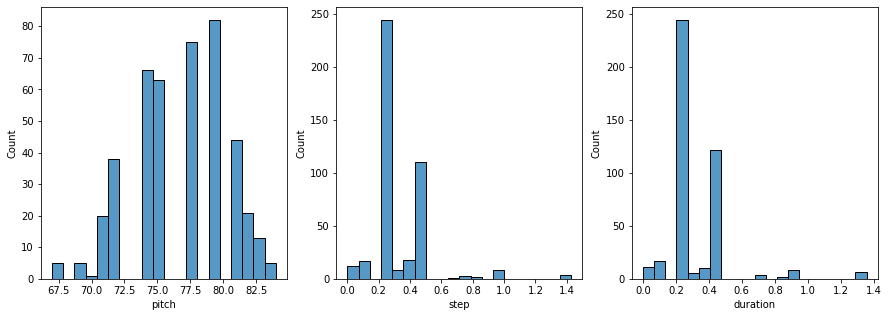

In [127]:
plot_distributions(raw_notes)

## Create a MIDI file


In [128]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [129]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Generated MIDI file.

In [130]:
display_audio(example_pm)

## Training dataset


In [131]:
num_files = 16
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [132]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 23802


In [133]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [134]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [135]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [136]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [137]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5234375 0.        0.25     ]
 [0.5546875 0.5       0.25     ]
 [0.578125  0.5       0.25     ]
 [0.6171875 0.5       1.425    ]
 [0.6328125 1.5       0.35625  ]
 [0.6171875 0.375     0.11875  ]
 [0.609375  0.125     0.2375   ]
 [0.59375   0.25      0.2375   ]
 [0.578125  0.25      0.2375   ]
 [0.5625    0.25      0.2375   ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=70.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.5>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.2375000000000007>}


In [138]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [139]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Train the model

In [140]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [141]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

In [142]:
losses = model.evaluate(train_ds, return_dict=True)
losses

371/371 [==============================] - 8s 9ms/step - loss: 5.2350 - duration_loss: 0.3093 - pitch_loss: 4.8509 - step_loss: 0.0748


{'duration_loss': 0.3093043863773346,
 'loss': 5.234997272491455,
 'pitch_loss': 4.850900650024414,
 'step_loss': 0.07479167729616165}

In [143]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [144]:
model.evaluate(train_ds, return_dict=True)

371/371 [==============================] - 5s 10ms/step - loss: 0.6266 - duration_loss: 0.3093 - pitch_loss: 4.8509 - step_loss: 0.0748


{'duration_loss': 0.3093043863773346,
 'loss': 0.6266412138938904,
 'pitch_loss': 4.850900650024414,
 'step_loss': 0.07479167729616165}

Train the model.

In [145]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [146]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
371/371 [==============================] - 10s 21ms/step - loss: 0.2493 - duration_loss: 0.0432 - pitch_loss: 3.7783 - step_loss: 0.0172
Epoch 2/50
371/371 [==============================] - 8s 20ms/step - loss: 0.2241 - duration_loss: 0.0394 - pitch_loss: 3.5651 - step_loss: 0.0064
Epoch 3/50
371/371 [==============================] - 8s 21ms/step - loss: 0.2196 - duration_loss: 0.0390 - pitch_loss: 3.5449 - step_loss: 0.0034
Epoch 4/50
371/371 [==============================] - 8s 20ms/step - loss: 0.2182 - duration_loss: 0.0387 - pitch_loss: 3.5373 - step_loss: 0.0026
Epoch 5/50
371/371 [==============================] - 8s 20ms/step - loss: 0.2182 - duration_loss: 0.0386 - pitch_loss: 3.5350 - step_loss: 0.0028
Epoch 6/50
371/371 [==============================] - 8s 21ms/step - loss: 0.2175 - duration_loss: 0.0384 - pitch_loss: 3.5306 - step_loss: 0.0025
Epoch 7/50
371/371 [==============================] - 8s 20ms/step - loss: 0.2172 - duration_loss: 0.0382 - pitch_los

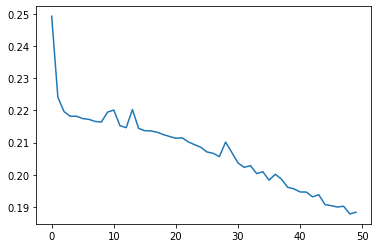

In [147]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

In [148]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [149]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [150]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,81,0.387963,0.432258,0.387963,0.820222
1,82,0.168147,0.146150,0.556111,0.702261
2,56,0.168068,0.149882,0.724179,0.874062
3,81,0.167702,0.149399,0.891881,1.041280
4,75,0.167219,0.147156,1.059100,1.206256
5,69,0.167779,0.149016,1.226879,1.375895
6,68,0.167646,0.148674,1.394525,1.543199
7,103,0.168564,0.151691,1.563089,1.714780
8,81,0.168268,0.150493,1.731357,1.881850
9,75,0.169245,0.153711,1.900602,2.054313


Generated MIDI file using RNN

In [151]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [153]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>